In [3]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

c:\Users\kagau\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_excel("finaldata.xlsx")

In [5]:
df.shape

(30620, 21)

In [6]:
# Data preparation
# ==============================================================================
data = df.copy()



In [7]:
data.dropna()

,TimeStamp,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,...,temp,rhum,msl,wdsp,wddir,day,month,hour,weekday,ElectricityPrice
0,2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,...,8.8,80,1034.7,9,250,1,1,0,1,70.28
1,2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,...,8.3,82,1034.7,9,250,1,1,1,1,65.18
2,2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,...,8.4,82,1034.7,8,240,1,1,2,1,60.91
3,2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,...,8.6,82,1035.2,8,250,1,1,3,1,65.16
4,2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,...,8.4,85,1035.5,10,250,1,1,4,1,65.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30615,2022-06-29 19:00:00,3978.34,3879.64,377.75,367.16,0.0931,116.3,456.0,146.4,96.5,...,15.8,73,1008.3,6,80,29,6,19,2,330.00
30616,2022-06-29 20:00:00,3843.57,3725.62,320.79,311.32,0.0751,92.3,450.7,123.8,93.6,...,14.5,80,1008.5,5,100,29,6,20,2,289.00
30617,2022-06-29 21:00:00,3796.31,3601.76,299.52,290.98,0.0668,80.5,450.7,122.2,93.6,...,14.0,77,1008.8,3,250,29,6,21,2,228.59
30618,2022-06-29 22:00:00,3754.00,3467.82,318.77,309.83,0.0732,59.7,340.1,121.5,96.1,...,13.3,82,1008.9,6,270,29,6,22,2,228.59


In [8]:
data['TimeStamp'] = pd.to_datetime(data['TimeStamp'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('TimeStamp')
data = data.asfreq('H')
data = data.sort_index()
data.head(2)

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,msl,wdsp,wddir,day,month,hour,weekday,ElectricityPrice
TimeStamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,1034.7,9.0,250.0,1.0,1.0,0.0,1.0,70.28
2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,1034.7,9.0,250.0,1.0,1.0,1.0,1.0,65.18


In [9]:
data=data.fillna(method='ffill')

In [10]:
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()

True

In [11]:
data['ElectricityPrice'] = data['ElectricityPrice'].fillna(0)

In [98]:

min_date = data.index.min()
max_date = data.index.max()
print("Min:", min_date, "Max:", max_date)


Min: 2019-01-01 00:00:00 Max: 2022-06-29 23:00:00


In [24]:

train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff


Timestamp('2021-08-14 23:15:00', freq='H')

In [25]:

days_between = time_between / np.timedelta64(1, 'D')
days_between


1275.9583333333333

In [26]:

train_days = 1260
train_cutoff = min_date + pd.DateOffset(train_days)


In [99]:

train_df = data[data.index <= train_cutoff]
test_df = data[data.index > train_cutoff]

print("Train:", train_df.index.min(), train_df.index.max(), len(train_df))
print("Test:", test_df.index.min(), test_df.index.max(), len(test_df))


Train: 2019-01-01 00:00:00 2022-06-14 00:00:00 30241
Test: 2022-06-14 01:00:00 2022-06-29 23:00:00 383


In [28]:
exog=train_df.loc[:, train_df.columns != 'ElectricityPrice']
exog.head()

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,SNSP,Hydro Run-of-River,Fossil hard coal,Fossil oil,Fossil peat,Fossil gas,temp,rhum,msl,wdsp,wddir,day,month,hour,weekday
TimeStamp,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2444.54,3005.92,599.98,599.15,0.4215,128.9,0.0,35.3,170.1,979.2,8.8,80.0,1034.7,9.0,250.0,1.0,1.0,0.0,1.0
2019-01-01 01:00:00,2326.80,2865.43,628.30,626.40,0.4324,128.4,0.0,28.2,225.0,808.3,8.3,82.0,1034.7,9.0,250.0,1.0,1.0,1.0,1.0
2019-01-01 02:00:00,1993.39,2613.60,517.65,513.24,0.4485,123.4,0.0,35.5,224.6,616.3,8.4,82.0,1034.7,8.0,240.0,1.0,1.0,2.0,1.0
2019-01-01 03:00:00,1752.69,2470.13,492.99,489.53,0.4832,124.1,0.0,35.6,190.7,451.6,8.6,82.0,1035.2,8.0,250.0,1.0,1.0,3.0,1.0
2019-01-01 04:00:00,1717.17,2384.35,424.52,378.44,0.4460,124.4,0.0,36.0,197.1,458.5,8.4,85.0,1035.5,10.0,250.0,1.0,1.0,4.0,1.0


In [45]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = HistGradientBoostingRegressor(),
                lags      = 10,
                transformer_y    = StandardScaler(),
                transformer_exog = None
             )

forecaster.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])
forecaster

C:\Users\kagau\anaconda3\lib\site-packages\skforecast\utils\utils.py:288: MissingValuesExogWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
  warnings.warn(
C:\Users\kagau\anaconda3\lib\site-packages\skforecast\utils\utils.py:288: MissingValuesExogWarning: `exog` has missing values. Most machine learning models do not allow missing values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=MissingValuesExogWarning)
  warnings.warn(


ForecasterAutoreg 
Regressor: HistGradientBoostingRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Demand', 'IE Wind Availability', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'msl', 'wdsp', 'wddir', 'day', 'month', 'hour', 'weekday'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2022-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'categorical_features': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_l

In [46]:
steps = len(test_df)

In [47]:
predictions = forecaster.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

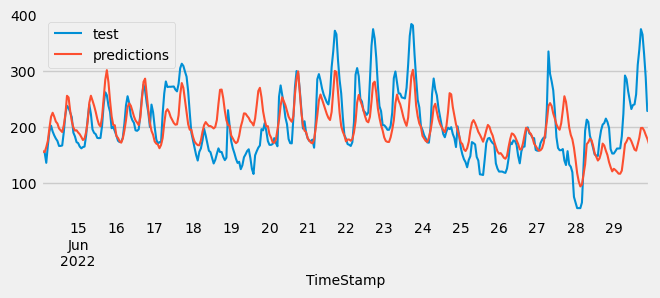

In [52]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [51]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test_df['ElectricityPrice'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 2151.377970961329


In [100]:
forecaster2 = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = steps, # Steps + gap
                 lags             = 24, # This value will be replaced in the grid search
                 transformer_y    = StandardScaler(),
                 transformer_exog = StandardScaler()
             )

In [101]:
forecaster2.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])

In [102]:


last_window = train_df['ElectricityPrice'].tail(25)
predictions2 = forecaster2.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'], last_window=last_window)

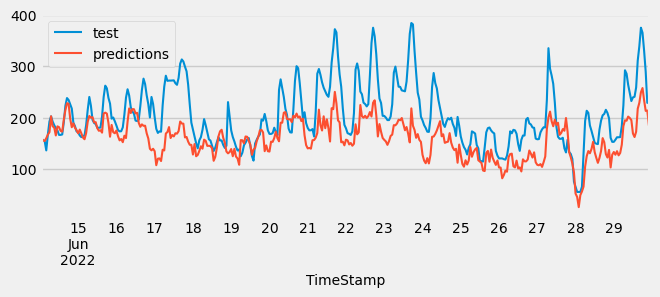

In [103]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions2.plot(ax=ax, label='predictions')
ax.legend();

In [105]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test_df['ElectricityPrice'],
                y_pred = predictions2
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 3789.962506456793


In [128]:
# Create and train forecaster
# ==============================================================================
forecaster3 = ForecasterAutoreg(
                 regressor        = Ridge(alpha=215.44, random_state=123),
                 lags             = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y    = StandardScaler(),
                 transformer_exog = None
             )


forecaster3.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])

predictions3 = forecaster3.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

# test error
# ==============================================================================
error = mean_absolute_error(
            y_true = test_df['ElectricityPrice'],
            y_pred = predictions3
        )


print(f"Backtest error: {error}")

Backtest error: 75.60852339224374


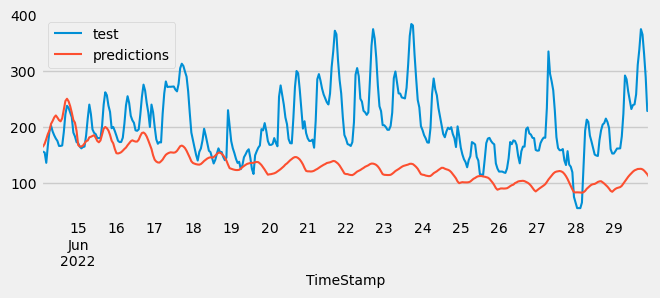

In [127]:
fig, ax = plt.subplots(figsize=(7, 2.5))
#train_df['ElectricityPrice'].plot(ax=ax, label='train')
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions3.plot(ax=ax, label='predictions')
ax.legend();

In [129]:
# Create and train forecaster
# ==============================================================================
forecaster4 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10
             )

forecaster4.fit(y=train_df['ElectricityPrice'], exog=train_df.loc[:, train_df.columns != 'ElectricityPrice'])
forecaster4

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['IE Generation', 'IE Demand', 'IE Wind Availability', 'IE Wind Generation', 'SNSP', 'Hydro Run-of-River', 'Fossil hard coal', 'Fossil oil', 'Fossil peat', 'Fossil gas', 'temp', 'rhum', 'msl', 'wdsp', 'wddir', 'day', 'month', 'hour', 'weekday'] 
Training range: [Timestamp('2019-01-01 00:00:00'), Timestamp('2022-06-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fracti

In [130]:
predictions4 = forecaster4.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

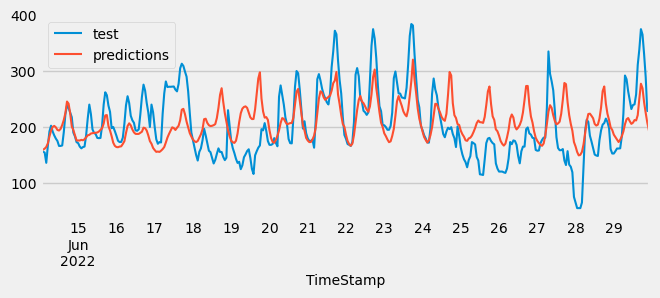

In [131]:
fig, ax = plt.subplots(figsize=(7, 2.5))
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions4.plot(ax=ax, label='predictions')
ax.legend();

In [133]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = test_df['ElectricityPrice'],
                y_pred = predictions4
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 2609.893806249466


In [136]:
# Hyperparameter Grid search
# ==============================================================================

#forecaster = ForecasterAutoreg(
               # regressor = RandomForestRegressor(random_state=123),
               # lags      = 12 # This value will be replaced in the grid search
             #)

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100],
              'max_depth': [3, 5]}

results_grid = grid_search_forecaster(
                    forecaster  = forecaster4,
                    y           = train_df['ElectricityPrice'],
                    exog        = train_df.loc[:, train_df.columns != 'ElectricityPrice'],
                    param_grid  = param_grid,
                    lags_grid   = lags_grid,
                    steps       = steps,
                    refit       = True,
                    metric      = 'mean_squared_error',
                    initial_train_size = int(len(train_df)*0.5),
                    return_best = True,
                    verbose     = False
               )

Number of models compared: 12.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 6317.3983461550015



In [137]:
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",6317.398346,5,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",6339.887760,5,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 100}",6674.096005,5,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",6777.071877,3,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",6782.798889,3,50
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",6795.224844,3,100
1,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 100}",6816.850697,3,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 100}",6823.032788,3,100
0,"[1, 2, 3, 4, 5]","{'max_depth': 3, 'n_estimators': 50}",6826.711314,3,50
3,"[1, 2, 3, 4, 5]","{'max_depth': 5, 'n_estimators': 100}",6831.743333,5,100


In [138]:
predictions5 = forecaster4.predict(steps=steps, exog=test_df.loc[:, test_df.columns != 'ElectricityPrice'])

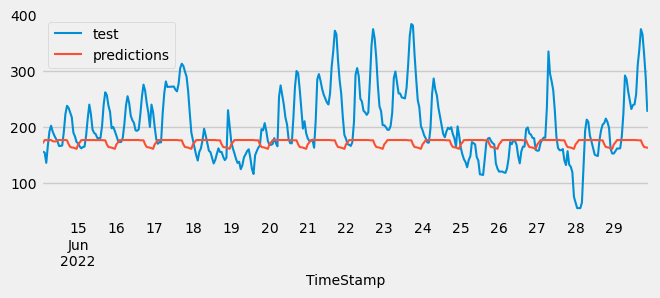

In [139]:
fig, ax = plt.subplots(figsize=(7, 2.5))
test_df['ElectricityPrice'].plot(ax=ax, label='test')
predictions5.plot(ax=ax, label='predictions')
ax.legend();